In [1]:
#!/usr/bin/python
import json
import sys
from operator import itemgetter
from os import listdir
from os.path import isfile, join, isdir
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   
    captions = ["Iteration",
                "Incremental Start",
                "Incremental End",
                "Incremental Duration",
                "Batch Start",
                "Batch End",
                "Batch Duration", 
                'Memory Min', 
                'Memory Max', 
                'Memory Mean', 'direct-used']

    data_frame = pd.DataFrame(columns=captions)
    data_frame.set_index('Iteration')

    onlyfiles = [f for f in listdir(event_dir) if isfile(join(event_dir, f)) and 'inprogress' not in f]

    for file in onlyfiles:
        with open(join(event_dir, file)) as f:
            
            content = f.readlines()
            batch_computation = False
            iteration_number = -1
            for line in content:
                event = json.loads(line)

                if event['Event'] == 'SparkListenerEnvironmentUpdate':
                    app_name = event['Spark Properties']['spark.app.name']
                    if app_name.startswith(analyze_app):
                        version = app_name.replace(analyze_app, '')
                        if not version:
                            version = '0'
                        if '_batch_' in version:
                            batch_computation = True
                            iteration_number = int(version.replace('_batch_', ''))
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number

                        else:
                            batch_computation = False
                            iteration_number = int(version)
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number




                if event['Event'] == 'SparkListenerJobStart':
                    start = event['Submission Time']
                    caption = 'Incremental Start'
                    if batch_computation:
                        caption = 'Batch Start'

                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = start

                if event['Event'] == 'SparkListenerJobEnd':
                    end = event['Completion Time']
                    caption = 'Incremental End'
                    if batch_computation:
                        caption = 'Batch End'
                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = end
                    
            if isdir(memory_dir):
                """
                 '.driver.jvm.heap.committed.csv',
                 '.driver.jvm.heap.init.csv',
                 '.driver.jvm.heap.max.csv',
                 '.driver.jvm.heap.usage.csv',
                 '.driver.jvm.heap.used.csv',
                 .driver.BlockManager.memory.memUsed_MB.csv
                """
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.used.csv'))
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.usage.csv'))
                try:
                    mem_df = pd.read_csv(join(memory_dir, file + '.driver.BlockManager.memory.memUsed_MB.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Min'] = mem_df['value'].min()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Max'] = mem_df['value'].max()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Mean'] = mem_df['value'].mean()
                    mem_df2 = pd.read_csv(join(memory_dir, file + '.driver.jvm.direct.used.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'direct-used'] = mem_df2['value'].mean()
                except:
                    continue
                
    data_frame['Incremental Duration'] = data_frame['Incremental End'] - data_frame['Incremental Start']
    data_frame['Batch Duration'] = data_frame['Batch End'] - data_frame['Batch Start']

    data_frame = data_frame.sort_values(['Iteration'], ascending=[True])
    data_frame = data_frame.set_index('Iteration')
    return data_frame

In [3]:
def collect_logs(log_dir, app_name, suffixes=[]):
    for suffix in suffixes:
        test_name = app_name + suffix
        in_dir = join(log_dir, test_name)
        #onlyfiles = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
        update_frame = pd.read_csv(join(in_dir, test_name + '-update-time-and-space.csv')) 
        #display(update_frame.head())
        #plot_nice(update_frame, ' Sec. Index Memory Size (bytes)', y_label='Object Size (MB)', scale_function=lambda x: x / 1024 / 1024)
        return update_frame

In [4]:
def get_sizeframe(dataset_dir):

    onlyfiles = [f for f in listdir(dataset_dir) if isfile(join(dataset_dir, f)) and f.endswith(".txt")]
    onlyfiles = sorted(onlyfiles)

    edgecounts = {}
    sizes = {}
    unzipped_sizes = {}
    tmp = 0
    for filename in onlyfiles:
        # first line: number of types in dataset (not unique)
        # second line: number of edges in dataset (not unique)
        # third line size bytes
        f = open(join(dataset_dir,filename), 'r')
        content = f.read().split('\n')
        #print(len(content))
        if len(content) > 2:
            edges = int(content[1])
        else:
            edges = int(content[0])

        size = int(content[2])

        if len(content) > 4:
            unzipped_size = int(content[3])

        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('.txt', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')

            edgecounts[int(iteration)] = edges
            sizes[int(iteration)] = size
            if len(content) > 4:
                unzipped_sizes[int(iteration)] = unzipped_size

        else:
            edgecounts[tmp] = edges
            sizes[tmp] = size
            if len(content) > 4:
                unzipped_sizes[tmp] = unzipped_size
            tmp = tmp + 1

    edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
    edgeframe = pd.DataFrame.sort_index(edgeframe)

    if len(content) > 4:
        sizeframe = pd.DataFrame.from_dict(unzipped_sizes, orient='index')
    else:
        sizeframe = pd.DataFrame.from_dict(sizes, orient='index')

    sizeframe = pd.DataFrame.sort_index(sizeframe)

    if data_size_dir == 'DyLDO-core':    
        edgeframe = edgeframe.drop(edgeframe.index[[21,22]])
        sizeframe = sizeframe.drop(sizeframe.index[[21,22]])

    sizeframe = sizeframe.applymap(lambda x: x / 1024 / 1024) 
    if len(content) <= 4:
        sizeframe = sizeframe.applymap(lambda x: x * 15) 

    sizeframe.columns=['Data Graph (Disk)']
    return sizeframe

In [5]:
out_dir = join('..', 'plots', 'memory_exp')
event_dir = join('..', 'data', 'spark_logs-memory_exp')
memory_dir = join(event_dir, 'spark-memory')
exp_log_dir = join('..', 'data', 'exp_logs-memory_exp', 'experiments')


In [13]:
data_dir = join('..', 'data', 'dataset_data')

app_name = 'BSBM-type-memory'
app_name = 'BSBM-schemex-memory'
app_name = 'BSBM-attribute-memory'
app_name = 'DyLDO-core-attribute-memory'
#app_name = 'DyLDO-core-schemex-memory'

data_size_dir = 'BSBM'
data_size_dir = 'DyLDO-core'

In [14]:
performance_frame = collectStatistics('%s-test-1' % app_name, event_dir, memory_dir)

In [15]:
update_frame = collect_logs(exp_log_dir, app_name, suffixes=['-test-1'])

In [16]:
size_frame = get_sizeframe(join(data_dir, data_size_dir))

In [17]:
memory_frame = pd.DataFrame()
memory_frame['Data Graph (Disk)'] = size_frame['Data Graph (Disk)']
memory_frame['Spark Memory'] = performance_frame['Memory Max']
memory_frame['VHI Memory'] = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024) 
#memory_frame = memory_frame.dropna()
display(memory_frame.head())

,Data Graph (Disk),Spark Memory,VHI Memory
0,2405.307897,10820,924.033661
1,2306.354592,10462,872.276924
2,2790.347591,12831,971.989204
3,2722.321526,12454,968.275185
4,2383.698988,10772,927.657249


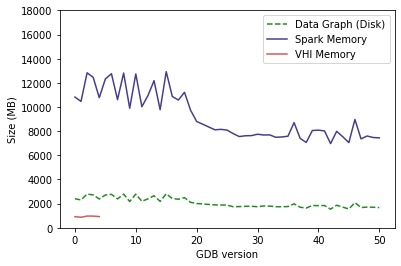

In [18]:
#print(edgeframe)
ax = memory_frame.plot(logy=False, style=['--', '-', '-', '-'], color=['forestgreen', 'darkslateblue', 'indianred', 'steelblue'])
                    
#'steelblue', 'steelblue', 'steelblue','indianred','indianred','indianred','indianred']) 

ax.set_ylabel("Size (MB)")
ax.legend(loc='upper right')
#ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], 
#color=['darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])

ax.set_xlabel("GDB version")
ax.set_ylim([0, 18000])
plt.savefig(out_dir + '/' + app_name + '.pdf', bbox_inches = 'tight')    
plt.savefig(out_dir + '/' + app_name + '.png', bbox_inches = 'tight', dpi=300)   

In [19]:
out_dir

'../plots/memory_exp'

In [20]:
overhead = memory_frame.dropna()['VHI Memory'] / memory_frame.dropna()['Spark Memory']
#display(overhead)
print(app_name)
print('memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))

DyLDO-core-attribute-memory
memory overhead is between 0.0688 and 0.0925 (mean: 0.0814 +- 0.0052)


In [21]:
disk_vs_memory = memory_frame['Spark Memory'] / memory_frame['Data Graph (Disk)']
print(app_name)
print('Memory per Disk space: %s (+- %s)' % (round(disk_vs_memory.mean(), 2), round(disk_vs_memory.std(), 2)))

DyLDO-core-attribute-memory
Memory per Disk space: 4.44 (+- 0.12)
